In [150]:
import sys
#!{sys.executable} -m pip install psutil

    100% |████████████████████████████████| 450kB 10.6MB/s a 0:00:01
  Running setup.py bdist_wheel for psutil ... done
  Stored in directory: /Users/anastasia/Library/Caches/pip/wheels/52/41/b0/bf50409fe2b1d3b79afa3eed71b54b3e30fe5b695db2c7ba2e
Successfully built psutil
You are using pip version 18.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [154]:
import operator
import re
import string
import enchant
import zipfile
import numpy as np
import pandas as pd

import gensim
from gensim.models import Word2Vec
from tqdm import tqdm
from numpy import copy

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer

from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Masking, SimpleRNN, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical, np_utils
from keras import regularizers

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [3]:
df = pd.read_csv("songs_dataset.csv")
df = df[["Genre", "Lyrics"]]

In [4]:
df

,Genre,Lyrics
0,"['Alternative/Indie', 'Hip-Hop/Rap']","\n\n[Hook: Gangsta Pat]\nKiller, killer, kille..."
1,['Hip-Hop/Rap'],"\n\nUh\n*59, yah!\nUhhhh, [?]\n*59 motherfucke..."
2,['Hip-Hop/Rap'],\n\n[Produced by Budd Dwyer]\n\n[Intro: Frayse...
3,['Hip-Hop/Rap'],\n\n[Verse 1: YUNG $NOW]\nCounting sheep until...
4,['Hip-Hop/Rap'],\n\n[Verse 1: RUBY DA CHERRY]\nFucking Ruby go...
...,...,...
253673,['Pop'],\n\n[Текст песни «Падать в грязь»]\n\n[Куплет ...
253674,"['Alternative/Indie', 'Pop']",\n\n[Текст песни «Последняя дискотека»]\n\n[Пр...
253675,['Pop'],"\n\n[Куплет 1]\nПод ногами снова лужи, рядом б..."
253676,['Pop'],\n\n[Куплет 1]\nМежду многоэтажек и суеты\nЯ н...


Adapted from: https://medium.com/@sabber/classifying-yelp-review-comments-using-lstm-and-word-embeddings-part-1-eb2275e4066b

In [5]:
def clean(text):  
    text = text.rstrip().lstrip()
    text = text.translate(string.punctuation)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]

    text = " ".join(text)
    text = text.replace('-', ' ')
    text = text.replace("+", " ")
    text = text.replace(":", " ")
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " ", text)
    text = re.sub(r"\=", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " ", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    if len(text) < 10:
        text = ""

    return text

In [6]:
# this takes a while but it's A-OKAY
df['Lyrics'] = df['Lyrics'].map(lambda x: clean(x))

In [7]:
df

,Genre,Lyrics
0,"['Alternative/Indie', 'Hip-Hop/Rap']",hook gangsta pat killer killer killer what fuc...
1,['Hip-Hop/Rap'],uh yah uhhhh motherfuck west bank bitch bout i...
2,['Hip-Hop/Rap'],produc budd dwyer intro frayser boy hit the hi...
3,['Hip-Hop/Rap'],vers yung now count sheep i am sound asleep i ...
4,['Hip-Hop/Rap'],vers rubi cherri fuck rubi got blunt flame tip...
...,...,...
253673,['Pop'],kia rio kia rio
253674,"['Alternative/Indie', 'Pop']",
253675,['Pop'],
253676,['Pop'],


In [8]:
# removing non-english lyrics
df = df.replace(r'^\s*$', np.nan, regex=True)
df = df.dropna()

In [9]:
df

,Genre,Lyrics
0,"['Alternative/Indie', 'Hip-Hop/Rap']",hook gangsta pat killer killer killer what fuc...
1,['Hip-Hop/Rap'],uh yah uhhhh motherfuck west bank bitch bout i...
2,['Hip-Hop/Rap'],produc budd dwyer intro frayser boy hit the hi...
3,['Hip-Hop/Rap'],vers yung now count sheep i am sound asleep i ...
4,['Hip-Hop/Rap'],vers rubi cherri fuck rubi got blunt flame tip...
...,...,...
253659,['Hip-Hop/Rap'],keep spend live keep spend live
253666,['Pop'],vers hook x vers hook x vers hook x
253669,['Pop'],pussi riot
253672,['Pop'],appl store


In [10]:
df['Genre'].unique()
# this is way too many!

array(["['Alternative/Indie', 'Hip-Hop/Rap']", "['Hip-Hop/Rap']",
       "['Rock']", "['Pop']", "['Rock', 'Alternative/Indie']",
       "['Rock', 'Pop']", "['Pop', 'Hip-Hop/Rap']",
       "['R&B/Soul', 'Hip-Hop/Rap']", "['Rock', 'Hip-Hop/Rap']",
       "['R&B/Soul', 'Blues/Jazz', 'Hip-Hop/Rap']",
       "['Metal', 'Rock', 'Alternative/Indie', 'Hip-Hop/Rap']",
       "['Pop', 'R&B/Soul', 'Blues/Jazz', 'Hip-Hop/Rap']", "['R&B/Soul']",
       "['Pop', 'R&B/Soul', 'Hip-Hop/Rap']",
       "['Rock', 'Alternative/Indie', 'Pop', 'Hip-Hop/Rap']",
       "['Rock', 'Punk', 'Hip-Hop/Rap']",
       "['Rock', 'Alternative/Indie', 'Hip-Hop/Rap']",
       "['Metal', 'Rock', 'Alternative/Indie']",
       "['Rock', 'Pop', 'Hip-Hop/Rap']", "['Rock', 'Punk', 'Pop']",
       "['Rock', 'Alternative/Indie', 'Pop']",
       "['Rock', 'Pop', 'R&B/Soul', 'Hip-Hop/Rap']",
       "['Folk', 'Rock', 'Hip-Hop/Rap']",
       "['Rock', 'R&B/Soul', 'Hip-Hop/Rap']", "['Folk', 'Rock']",
       "['Folk', 'Rock', 'R&B/Soul

In [11]:
df['Genre'].value_counts()

['Pop']                                                             101933
['Hip-Hop/Rap']                                                      53472
['Rock']                                                             30653
['Country']                                                           8374
['Rock', 'Country']                                                   5823
                                                                     ...  
['Folk', 'Alternative/Indie', 'Pop', 'Country', 'R&B/Soul']              1
['Rock', 'Pop', 'Country', 'Hip-Hop/Rap']                                1
['Metal', 'Rock', 'Alternative/Indie', 'Country', 'Hip-Hop/Rap']         1
['Rock', 'Punk', 'Alternative/Indie', 'Pop', 'Country']                  1
['Metal', 'Rock', 'Blues/Jazz', 'Hip-Hop/Rap']                           1
Name: Genre, Length: 223, dtype: int64

In [12]:
df['Genre'].value_counts(sort=True, ascending=False)[:4]

['Pop']            101933
['Hip-Hop/Rap']     53472
['Rock']            30653
['Country']          8374
Name: Genre, dtype: int64

In [13]:
def format_genre(genre):
    genre = genre.rstrip().lstrip()
    genre_list = genre.lower().split(",")
    genre = genre_list[len(genre_list) - 1]
    genre = genre.translate(string.punctuation)
    genre = genre.replace("-", "").replace("/", "").replace("[", "").replace("]", "").replace("'", "").replace("&", "")
    genre = genre.rstrip().lstrip()
    return genre

In [14]:
df['Genre'] = df['Genre'].map(lambda x: format_genre(x))

In [15]:
df

,Genre,Lyrics
0,hiphoprap,hook gangsta pat killer killer killer what fuc...
1,hiphoprap,uh yah uhhhh motherfuck west bank bitch bout i...
2,hiphoprap,produc budd dwyer intro frayser boy hit the hi...
3,hiphoprap,vers yung now count sheep i am sound asleep i ...
4,hiphoprap,vers rubi cherri fuck rubi got blunt flame tip...
...,...,...
253659,hiphoprap,keep spend live keep spend live
253666,pop,vers hook x vers hook x vers hook x
253669,pop,pussi riot
253672,pop,appl store


In [16]:
df_t1 = df.loc[(df['Genre'] == 'pop')]
df_t2 = df.loc[(df['Genre'] == 'rock')]
df_t3 = df.loc[(df['Genre'] == 'country')]
df_t4 = df.loc[(df['Genre'] == 'hiphoprap')]
df_4gen = pd.concat([df_t1, df_t2, df_t3, df_t4])
df_4gen = df_4gen.sample(frac=1).reset_index(drop=True)

In [17]:
df_4gen = df_4gen.replace(r'^\s*$', np.nan, regex=True)
df_4gen = df_4gen.dropna()

In [18]:
df_4gen['Genre'].unique()

array(['pop', 'hiphoprap', 'country', 'rock'], dtype=object)

# Balancing it out

In [23]:
df_4gen['Genre'].value_counts()

pop          112470
hiphoprap     61672
rock          33830
country       15376
Name: Genre, dtype: int64

In [24]:
df_final = (df_4gen.groupby('Genre', as_index=False)
        .apply(lambda x: x.sample(n=15376))
        .reset_index(drop=True))

In [25]:
df_final = df_final.sample(frac=1).reset_index(drop=True)

In [26]:
df_final

,Genre,Lyrics
0,country,vers if ever blue know feel if ever blue know ...
1,pop,one intend ever think her i one let en life wi...
2,pop,again tellin sorri babi tellin want come a bac...
3,hiphoprap,vers wiley if draw five day then ai not got wo...
4,country,sung pretti paper pretti ribbon blue spoken ma...
...,...,...
61499,pop,play band we are best land we are big chelsea ...
61500,rock,vers i am reason women bleed it call the curs ...
61501,pop,word music by irv berlin to long held close he...
61502,pop,choic alway problem you what need someon stron...


### Mapping genres to numbers

In [27]:
genre_map = {'hiphoprap': 0, 'rock': 1, 'pop': 2, 'country': 3}
df_final = df_final.applymap(lambda s: genre_map.get(s) if s in genre_map else s)

In [28]:
df_final

,Genre,Lyrics
0,3,vers if ever blue know feel if ever blue know ...
1,2,one intend ever think her i one let en life wi...
2,2,again tellin sorri babi tellin want come a bac...
3,0,vers wiley if draw five day then ai not got wo...
4,3,sung pretti paper pretti ribbon blue spoken ma...
...,...,...
61499,2,play band we are best land we are big chelsea ...
61500,1,vers i am reason women bleed it call the curs ...
61501,2,word music by irv berlin to long held close he...
61502,2,choic alway problem you what need someon stron...


# Tokenizing

In [41]:
vocabulary_size = 400000 #20000
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(df_final['Lyrics'])
sequences = tokenizer.texts_to_sequences(df_final['Lyrics'])
data = pad_sequences(sequences, maxlen=100)
labels = df_final['Genre']

# Gensim Continuous Skipgram Embeddings

http://vectors.nlpl.eu/repository/# -- pre-trained model #3

In [46]:
embeddings_index = {}
f = open('3/model.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 296631 word vectors.


In [47]:
embedding_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

# Training

In [48]:
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [49]:
y_binary = np_utils.to_categorical(labels)

In [50]:
np.shape(y_binary)

(61504, 4)

You are passing a target array of shape (16192, 1) while using as loss `categorical_crossentropy`. `categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes). If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead, which does expect integer targets.


# Training

In [52]:
early_stopping_monitor = EarlyStopping(patience=3)

model = Sequential()
model.add(Embedding(vocabulary_size, 100, input_length=100, weights=[embedding_matrix]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(10 0, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 15
batch_size = 32

history = model.fit(data, np.array(y_binary), epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
model.save('./model_lyrics.h5')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 49203 samples, validate on 12301 samples
Epoch 1/15
49203/49203 [==============================] - 1691s 34ms/step - loss: 1.0595 - accuracy: 0.5020 - val_loss: 0.9561 - val_accuracy: 0.5839
Epoch 2/15
49203/49203 [==============================] - 1400s 28ms/step - loss: 0.8757 - accuracy: 0.6344 - val_loss: 0.9059 - val_accuracy: 0.6149
Epoch 3/15
49203/49203 [==============================] - 1321s 27ms/step - loss: 0.7646 - accuracy: 0.6920 - val_loss: 0.8820 - val_accuracy: 0.6443
Epoch 4/15
49203/49203 [==============================] - 1285s 26ms/step - loss: 0.6969 - accuracy: 0.7269 - val_loss: 0.8778 - val_accuracy: 0.6426
Epoch 5/15
49203/49203 [==============================] - 1274s 26ms/step - loss: 0.6174 - accuracy: 0.7595 - val_loss: 0.8975 - val_accuracy: 0.6454
Epoch 6/15
49203/49203 [==============================] - 1518s 31ms/step - loss: 0.5511 - accuracy: 0.7892 - val_loss: 0.9434 - val_accuracy: 0.6469
Epoch 7/15
49203/49203 [==========================

# Viz

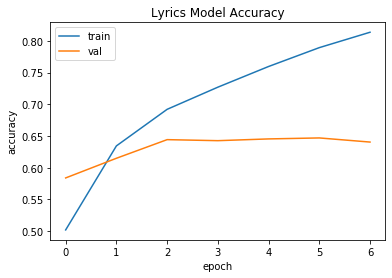

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Lyrics Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

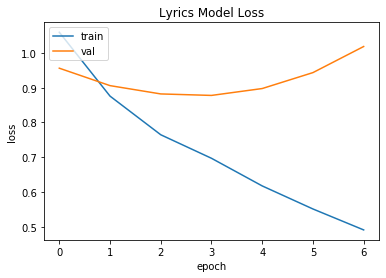

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Lyrics Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# TESTING TAYLOR SWIFT

In [59]:
ts_df = pd.read_csv("taylor_swift_lyrics.csv")

In [60]:
ts_df

,artist,album,track_title,track_n,lyric,line,year
0,Taylor Swift,Taylor Swift,Tim McGraw,1,He said the way my blue eyes shined,1,2006
1,Taylor Swift,Taylor Swift,Tim McGraw,1,Put those Georgia stars to shame that night,2,2006
2,Taylor Swift,Taylor Swift,Tim McGraw,1,"I said, ""That's a lie""",3,2006
3,Taylor Swift,Taylor Swift,Tim McGraw,1,Just a boy in a Chevy truck,4,2006
4,Taylor Swift,Taylor Swift,Tim McGraw,1,That had a tendency of gettin' stuck,5,2006
...,...,...,...,...,...,...,...
4857,Taylor Swift,reputation,New Year's Day,15,"(Hold on to the memories, they will hold on to...",43,2017
4858,Taylor Swift,reputation,New Year's Day,15,Please don't ever become a stranger,44,2017
4859,Taylor Swift,reputation,New Year's Day,15,"(Hold on to the memories, they will hold on to...",45,2017
4860,Taylor Swift,reputation,New Year's Day,15,Whose laugh I could recognize anywhere,46,2017


In [72]:
ts_df['year'].unique()

array([2006, 2008, 2010, 2012, 2014, 2017])

In [73]:
ts_df['album'].unique()

array(['Taylor Swift', 'Fearless', 'Speak Now', 'Red', '1989',
       'reputation'], dtype=object)

In [116]:
ts = ts_df.groupby(['track_title', 'year'], sort=False).lyric.apply(' '.join).reset_index(name='lyrics')

In [117]:
ts

,track_title,year,lyrics
0,Tim McGraw,2006,He said the way my blue eyes shined Put those ...
1,Picture To Burn,2006,"State the obvious, I didn't get my perfect fan..."
2,Teardrops On My Guitar,2006,Drew looks at me I fake a smile so he won't se...
3,A Place In This World,2006,"I don't know what I want, so don't ask me Caus..."
4,Cold as You,2006,You have a way of coming easily to me And when...
...,...,...,...
89,Dancing With Our Hands Tied,2017,"I, I loved you in secret First sight, yeah, we..."
90,Dress,2017,Our secret moments in a crowded room They got ...
91,This Is Why We Can't Have Nice Things,2017,It was so nice throwing big parties Jump into ...
92,Call It What You Want,2017,My castle crumbled overnight I brought a knife...


In [118]:
ts['lyrics'] = ts['lyrics'].map(lambda x: clean(x))

In [119]:
tokenizer_taylor = Tokenizer(num_words= vocabulary_size)
tokenizer_taylor.fit_on_texts(ts['lyrics'])
sequences_taylor = tokenizer_taylor.texts_to_sequences(ts['lyrics'])
taylor_test = pad_sequences(sequences_taylor, maxlen=100)

In [120]:
predictions_taylor = model.predict_classes(taylor_test)

In [121]:
predictions_taylor

array([2, 2, 2, 0, 3, 1, 2, 1, 3, 2, 0, 3, 3, 3, 3, 3, 0, 1, 1, 3, 0, 0,
       0, 0, 3, 2, 3, 3, 1, 1, 3, 1, 1, 1, 0, 1, 3, 2, 3, 3, 3, 2, 0, 0,
       0, 2, 2, 1, 1, 2, 0, 2, 2, 2, 3, 3, 0, 2, 2, 2, 2, 1, 0, 0, 0, 0,
       0, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 1, 1, 3, 3, 2, 3, 3, 1, 2, 3, 0,
       2, 2, 0, 1, 0, 2])

In [123]:
ts_v2 = ts
ts_v2['genre'] = predictions_taylor

In [124]:
tsp = []
for p in predictions_taylor:
    if p == 0:
        tsp.append('hiphoprap')
    if p == 1:
        tsp.append('rock')
    if p == 2:
        tsp.append('pop')
    if p == 3:
        tsp.append('country')
tsp = np.array(tsp)
ts['genre'] = tsp

In [128]:
ts

,track_title,year,lyrics,genre
0,Tim McGraw,2006,said way blue eye shine put georgia star shame...,pop
1,Picture To Burn,2006,state obvious get perfect fantasi realiz love ...,pop
2,Teardrops On My Guitar,2006,drew look fake smile see want i am need everyt...,pop
3,A Place In This World,2006,know want ask caus i am still tri figur know w...,hiphoprap
4,Cold as You,2006,way come easili take take best start fight cau...,country
...,...,...,...,...
89,Dancing With Our Hands Tied,2017,love secret first sight yeah love without reas...,pop
90,Dress,2017,secret moment crowd room got idea indent shape...,hiphoprap
91,This Is Why We Can't Have Nice Things,2017,nice throw big parti jump pool balconi everyon...,rock
92,Call It What You Want,2017,castl crumbl overnight brought knife gunfight ...,hiphoprap


In [145]:
fig = go.Figure(go.Scatter(
    mode = "lines+markers",
    y = ts['genre'],
    x = ts['track_title'],
    name="Progression of Taylor Swift songs over years"))

fig.update_layout(
    xaxis = go.layout.XAxis(
        tickangle = 90,
        title_font = {"size": 2},
        title_standoff = 25),
    yaxis = go.layout.YAxis(
        title_text = "Genre",
        title_standoff = 25),
    title={
        'text': "Progression of Taylor Swift songs over years",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.update_xaxes(showticklabels=False)

fig.show()